# Audio Tagging (Classification)

In [1]:
#importing necessary packages
import os
import feather
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
% matplotlib inline

## Introduction

Due to the vastness of sounds we experience, no reliable automatic general-purpose audio tagging systems curently exists. Therefore, a lot of manual effort is required for tasks like annotating sound collections and providing captions for non-speech events in audiovisual content. This need for more research and development in that area got us very excited in the problem which we chose to tackle via probabilistic programming. 

**Goal:** Develop an automatic, general-purpose audio tagging system capable of accurately classifying sound collections for a wide range of real-world environments.

## Data

The original dataset is taken from Kaggle (Audio Tagging competition). The samples (~20,000 WAV files) are generated from Freesound's library and include things like musical instruments, domestic sounds, and animals. Each input represents a WAV file with a corresponding annotative label. The dataset also includes a boolean column indicating whether the label was manually verified by a human.

In [2]:
train = pd.read_csv("data_overview/train.csv")
train.head()

fname         label  manually_verified
0  00044347.wav        Hi-hat                  0
1  001ca53d.wav     Saxophone                  1
2  002d256b.wav       Trumpet                  0
3  0033e230.wav  Glockenspiel                  1
4  00353774.wav         Cello                  1

The train set includes ~9500 audio files associated with 41 unique labels, each generated by Google’s AudioSet ontology.

In [3]:
print('Number of training examples (audiofiles): {}'.format(train.shape[0]))
print('Number of unique categories: {}'.format(train['label'].nunique()))

Number of training examples (audiofiles): 9473
Number of unique categories: 41


Here's an example of an audio file (part of the training datatset) labeled under 'Cowbell':

Cowbell Labeled Audiofile


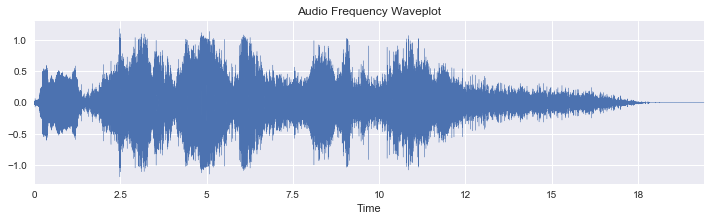

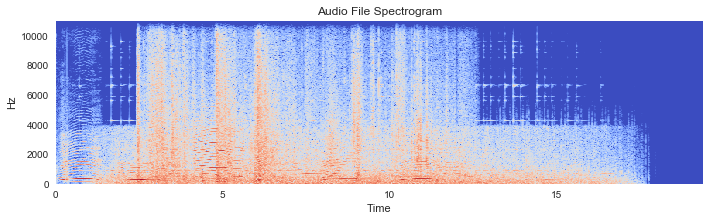

In [4]:
% run py-script/run_example.py

It is important to mention that the dataset has a rather diverse distribution of audio duration that presented a certain modeling challenge (as compared to more normalized classification problems where the vector space dimentionality is aligned across all datapoints). Below you can see the duration distirbution by label in the training dataset:

![](plots/violin_plot_duration.png)

In the preprocessing stages, we have addressed that concern by testing a number of different normalization techniques to represent the audio files within the same dimention. Those techniques included:
1. Choosing optimal max length (net strong outliers) and padding other audio files with silence to reach equal size
2. Choosing optimal length (net strong outliers) and trimming all larger audio files to chosen length (dropping anything below benchmark)
3. Describing the dataset through statistical values like average lenght, kurtosis, etc

Moving forward with the analysis, we have kept in mind that those preprocessing approaches may have introduced a certain bias to our dataset that might need to be taken into consideration during critisism stages.

In order to run this notebook in a reasonable amount of time, we will be importing a small subset of the data post preprocessing (each audio file represented as a normalized frequency vector) rather than the entire dataset. Nonetheless, the visual and numerical results presented in the following sections were based on the calculations made on the entire dataset.

In [2]:
# importing the sample audio files vector representations post preprocessing
train_data = feather.read_dataframe('data_overview/train_data.feather')
test_data = feather.read_dataframe('data_overview/test_data.feather')

## Box's Loop Journey Graph

Below is a short summary graph of our journey of iterating through the Box's loop in deriving the final audio-tagging model.


![](plots/journey.png)

## Box's Loop: First Iteration

### Model: Probabilistic PCA

## The Model

Consider a data set $\mathbf{X} = \{\mathbf{x}_n\}$ of $N$ data
points, where each data point is $D$-dimensional, $\mathbf{x}_n \in
\mathbb{R}^D$. We aim to represent each $\mathbf{x}_n$ under a latent
variable $\mathbf{z}_n \in \mathbb{R}^K$ with lower dimension, $K <
D$. The set of principal axes $\mathbf{W}$ relates the latent variables to
the data.

Specifically, we assume that each latent variable is normally distributed,

\begin{equation*}
\mathbf{z}_n \sim N(\mathbf{0}, \mathbf{I}).
\end{equation*}

The corresponding data point is generated via a projection,

\begin{equation*}
\mathbf{x}_n \mid \mathbf{z}_n
\sim N(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I}),
\end{equation*}

where the matrix $\mathbf{W}\in\mathbb{R}^{D\times K}$ are known as
the principal axes. In probabilistic PCA, we are typically interested in
estimating the principal axes $\mathbf{W}$ and the noise term
$\sigma^2$.

Probabilistic PCA generalizes classical PCA. Marginalizing out the the
latent variable, the distribution of each data point is

\begin{equation*}
\mathbf{x}_n \sim N(\mathbf{0}, \mathbf{W}\mathbf{W}^\top + \sigma^2\mathbf{I}).
\end{equation*}

Classical PCA is the specific case of probabilistic PCA when the
covariance of the noise becomes infinitesimally small, $\sigma^2 \to 0$.

We set up our model below. In our analysis, we assume $\sigma$ is known, and
instead of point estimating $\mathbf{W}$ as a model parameter, we
place a prior over it in order to infer a distribution over principal
axes. [1][2]

*** The model description is taken from the [Edward PPCA tutorial](http://edwardlib.org/tutorials/probabilistic-pca). 

### Variational Inference

We use variational inference, where the posterior distribtion $p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X})$ is approximated using a variational distribution $q(\mathbf{W}, \mathbf{Z})$ parametrised by $\boldsymbol{\lambda}$. The aim is to find the variational parameters $\boldsymbol{\lambda}$ that _minimize_ the KL divergence between q and the posterior, $\mathrm{KL}(q(\mathbf{W}, \mathbf{Z}) \mid\mid p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X}))$, or equivalently, that _maximize_ the evidence lower bound, $\mathbb{E}_{q(\mathbf{W},\mathbf{Z};\boldsymbol{\lambda})}\left[ \log p(\mathbf{W},\mathbf{Z},\mathbf{X}) - \log q(\mathbf{W},\mathbf{Z}; \boldsymbol{\lambda}) \right]$.

To keep the running time reasonable, the following code only applies the model to two labels (while working with 41 in the actual dataset) with 10 audio files each. Nonetheless, the results reported in criticism are based on our analysis of the entire dataset. 

*** VI description is also taken from [Edward PPCA tutorial](http://edwardlib.org/tutorials/probabilistic-pca).

Training PPCA for label: Acoustic_guitar


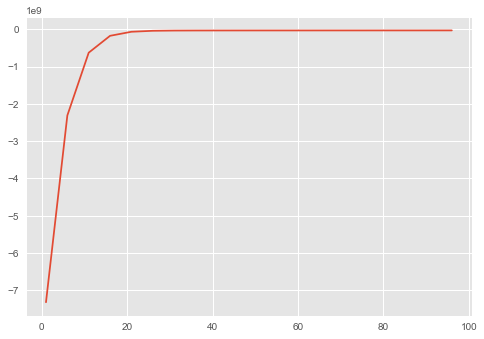

Training PPCA for label: Laughter


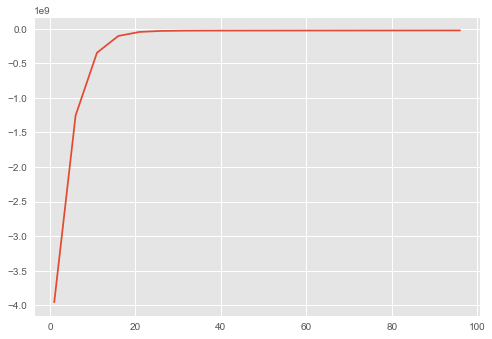

In [6]:
% run py-script/ppca.py
for label in train_data['label'].unique():
    print("Training PPCA for label: {}".format(label))
    x_train = train_data.loc[train_data['label']==label].copy()
    y_train = x_train.pop('label')
    
    x_train = x_train.transpose() 
    data_dim = x_train.shape[0]
    num_datapoints = x_train.shape[1]
    
    training_result = train_ppca(x_train, data_dim, latent_dim, num_datapoints, stddv_datapoints)
    training_results.append((label, training_result))

### Criticism

The proposed framework in then criticised by applying two different approaches:

1. Based on the derived Probabilistic PCA parameters, we are able to pull samples from the generated distributions for each label. Our expectation is that the sample audio waves should resemble (sound) similar to those in their corresponding classes.
2. The classification accuracy can be estimated by calculating individual label probabilities of each test data point (audio file) while assigning the label with highest returned probability. The final label assignment is then compared to the true test label to determine whether the model classified the point correctly.

Applying the first method, we pull a sample audio file to assess its audio resemblence.

Generated Audio File for: Acoustic Guitar


<Figure size 576x396 with 0 Axes>

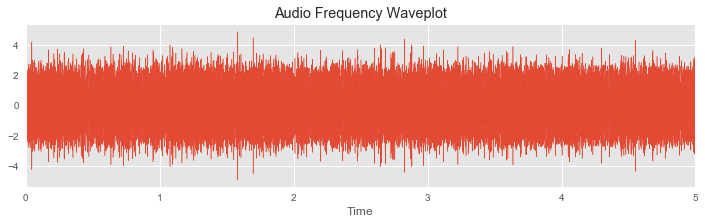

In [7]:
% run py-script/play_generated_sample.py
play_sample(training_results)

Unfortunately, listening back to the file, it doesn't sound like any acoustic guitar that we've ever heard. Given the poor performance of the sampled distribution, we do not expect the classification accuracy rate to be high. Nonetheless, to establish a benchmark for future iterations, we have calculated it below. 

In [8]:
% run py-script/accuracy_calc.py
sess = tf.InteractiveSession()
y_test = test_data['label']
y_test = y_test.replace({'Acoustic_guitar': 0, 'Laughter': 1})
x_test = test_data.drop(['label'], axis=1)
label_probabilities = calculate_probability(training_results, 2, latent_dim, stddv_datapoints, np.array(x_test))
assignments = assign_class(label_probabilities)
test_accuracy = accuracy_score(y_test, assignments)
print('Accuracy Score on Test Set: {}%'.format(test_accuracy*100))

Accuracy Score on Test Set: 46.666666666666664%


<Figure size 576x396 with 0 Axes>

A pretty low benchmark! At this point we will be better off guessing. It is important to mention that when tested against the entire dataset, the accuracy rate was even lower due to multi-class complexity not reflected in the sample dataset used in this notebook(~25% on average). 

The poor performance of this model could be possibly explained by the fact that the latent dimentiality chosen for the model was too low given the complexity of the audio files (more than 10,000 features). Testing this hypothesis, we looked at the accuracy rate movement based on different settings of latent dimensionality. Looking at the chart above, increasing the dimensionality does not seem to improve classification accuracy. Therefore, this hypothesis does not seem to be likely.


![](plots/librosa_dim_accuracy.png)
 

As mentioned in the **Data** part of this notebook, we chose to apply the model on three different processing methodologies. The hypothesis was that perhaps a certain preprocessing approach would perform better than the rest. The chart above also shows the difference in their performance. As seen from the graph, the difference is not as drastic as expected.

One last explaination of poor performance could be that linear methods are unable to model the structure in our data. Therefore, using probabilistic PCA does not provide for the best method given the problem setting.

Taking into consideration both of those critiques, there is a clear need for a more complex model that:
1. Does a better job capturing the structure of the data (ie. can generate label samples that are audible)
2. Scales to large datasets
3. Provides for a framework no classify latent space that might not be linearly separable by default

These considerations suggest that, for the next iteration of the Box's loop, a variational autoencoder (VAE) may be a good choice as it is in keeping with our latent variable modeling approach, but allows for a non-linear mapping between the latent space and the observed space.

## Box's Loop: Second Iteration

### Model: CNN VAE Mixture (Trained for each label)

Simularly to the PPCA, a variational autoencoder (VAE) models the relationship between the data $x$ and latent variables $z$. Rather than a model per se, a VAE is really the combination of a generative model and an inference network, which are often referred to as a probabilistic decoder and probabilistic encoder, respectively.

We start in the Variational Inference setting, with a distribution $q(\mathbf{t} \lvert \mathbf{x};\mathbf\phi)$ that has a fixed number of parameters $\mathbf\phi$ and is an approximation for the true but unknown posterior $p(\mathbf{t} \lvert \mathbf{x};\mathbf\theta)$. To implement the (complex) functions $m$ and $s$ that map from an input data point (WAV file) to the mean and the variance of that distribution we can use a [convolutional neural network](https://de.wikipedia.org/wiki/Convolutional_Neural_Network) (CNN) that is parameterized by $\mathbf\phi$. 

Similarly, for implementing $p(\mathbf{x} \lvert \mathbf{t};\mathbf\theta)$ we can use another neural network, parameterized by $\mathbf\theta$, that maps a latent vector $\mathbf{t}$ to the sufficient statistics of that probability distribution. Since $\mathbf{t}$ is often a lower-dimensional embedding or code $\mathbf{x}$, $q(\mathbf{t} \lvert \mathbf{x};\mathbf\phi)$ is referred to as *probabilistic encoder* and $p(\mathbf{x} \lvert \mathbf{t};\mathbf\theta)$ as *probabilistic decoder*.

Both, encoder and decoder, can be combined to a *variational auto-encoder* that is trained with the variational lower bound $\mathcal{L}$ as optimization objective. For our model, the variational lower bound for a single training object $\mathbf{x}^{(i)}$ can also be formulated as:

$$
\mathcal{L}(\mathbf\theta, \mathbf\phi, \mathbf{x}^{(i)}) =
  \mathbb{E}_{q(\mathbf{t} \lvert \mathbf{x}^{(i)};\mathbf\phi)} \left[\log p(\mathbf{x}^{(i)} \lvert \mathbf{t};\mathbf\theta)\right] - 
  \mathrm{KL}(q(\mathbf{t} \lvert \mathbf{x}^{(i)};\mathbf\phi) \mid\mid p(\mathbf{t}))
$$

The first term is the expected negative *reconstruction error* of the data point $\mathbf{x}^{(i)}$. It is computed by first feeding an input audio vector $\mathbf{x}^{(i)}$ through the encoder to compute the mean and the variance of the variational distribution $q(\mathbf{t} \lvert \mathbf{x};\mathbf\phi)$. To compute an approximate value of the expected negative reconstruction error, we sample from the variational distribution. Since this is a Gaussian distribution, sampling is very efficient. To compute $p(\mathbf{x} \lvert \mathbf{t};\mathbf\theta)$ we feed the samples through the decoder. A single sample per training object is usually sufficient<sup>[4]</sup> if the mini-batch size during training is large enough e.g. > 100.

![vae-2](plots/vae_3.png)

The negative KL divergence is maximized when the approximate posterior $q(\mathbf{t} \lvert \mathbf{x};\mathbf\phi)$ is equal to the prior $p(\mathbf{t})$. The prior is usually chosen to be the standard normal distribution $\mathcal{N}(\mathbf{0},\mathbf{I})$. This term therefore acts as a regularization term to avoid that the variance of $q(\mathbf{t} \lvert \mathbf{x};\mathbf\phi)$ becomes zero, otherwise, $q(\mathbf{t} \lvert \mathbf{x};\mathbf\phi)$ would degenerate to a delta function and the variational auto-encoder to a usual auto-encoder. Regularizing $q(\mathbf{t} \lvert \mathbf{x};\mathbf\phi)$ to have non-zero variance makes the decoder more robust against small changes in $\mathbf{t}$ and the latent space a continuous space of codes that can be decoded to realistic images. 

*** The statistical description of the model above was taken from a [helpful VAE tutorial](https://github.com/krasserm/bayesian-machine-learning/blob/master/variational_autoencoder.ipynb).

### Variational Inference

Variational inference approximates the posterior with a family of distributions $q_{\phi}(z∣x)$. The variational parameter $\phi$ indexes the family of distributions.

In the variational autoencoder model, there are only local latent variables (no datapoint shares its latent z with the latent variable of another datapoint). By Jensen’s inequality, minimizing the Kullback-Leibler divergence is equivalent to maximizing the ELBO. So we can decompose the ELBO into a sum where each term depends on a single datapoint. This allows us to use stochastic gradient descent with respect to the parameters $\phi$. The ELBO for a single datapoint in the variational autoencoder is:

\begin{equation}
ELBO_{i}(\theta, \phi) =  E_{q_{\theta}(z∣x_{i})}[logp_{\phi}(x_{i}∣z)]−KL(q_{\theta}(z∣x_{i} )∣∣p(z))
\end{equation}

In [3]:
% run py-script/vae.py
estimators = fit_cnn_vae(train_data)

Training VAE for label: Acoustic_guitar
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/r4/2ycms2t97b9gtyx7hw1xf51r0000gn/T/tmp0jy5gw2h', '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_num_worker_replicas': 1, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a25236908>, '_task_id': 0, '_task_type': 'worker', '_keep_checkpoint_every_n_hours': 10000, '_global_id_in_cluster': 0, '_log_step_count_steps': 100, '_master': '', '_protocol': None, '_num_ps_replicas': 0, '_is_chief': True, '_experimental_distribute': None, '_service': None, '_train_distribute': None, '_eval_distribute': None, '_evaluation_master': '', '_save_checkpoints_steps': 100, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_tf_random_seed': None, '_device_fn': None}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions f

### Criticism

While training on the entire dataset, we made heavy use of Tensorboard to track the training progress. In particular, we frequently generated audio samples that provided quick feedback as to how well the VAE was modelling the structure of the data. 

In addition, we found the 3-dimensial PCA approximations of the latent space to be very useful.

#### Modeling the laten space as a single cluster

![](plots/cnn_vae_poor.png)

#### Modeling rich structure in the latent space

![](plots/cnn_vae_good.png)

#### A snapshot from early in the training epochs

![](plots/cnn_vae_beginning.png)

#### A snapshot once training had completed

![](plots/cnn_vae_end.png)

Let us listen to some of the sample data point generated when training for the acoustic guitar label and see if it is more audible than the one returned by the PPCA. The sample file presented below was generated by fitting the entire dataset rather than the sample view offered and analyzed in this notebook.

Drawn Sample From VAE Generated Acoustic Guitar Class


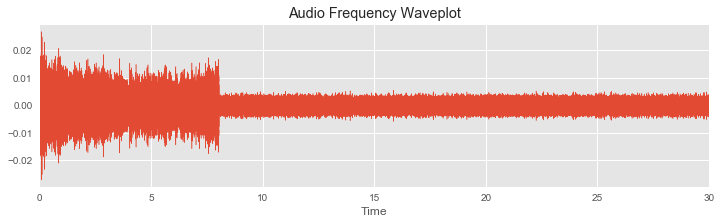

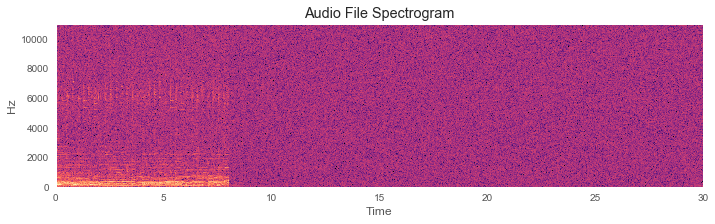

In [10]:
run_gen_example('VAE_guitar.wav')

Indeed, overlooking some of the white noise in the background, the generated sample does seem to pick up a lot of the features common in the guitar sound and can even be recognized as such by humans. We believe this is rather remarkable! Right away, the new model choice seem to show an improvement over the older model.

But what about the classification accuracy rates? Let us take a look at how well mixture VAE performed at that task.

The `model_fn` of each of our `tf.estimator.Estimator` object has the full `.predict()` implementation, but the basic idea is:

```python

approx_posterior = encoder(test_point)
approx_posterior_sample = approx_posterior.sample(1)
decoder_likelihood = decoder(approx_posterior_sample)
log_likelihood = decoder_likelihood.log_prob(test_point)

return tf.reduce_mean(log_likelihood)
```

For prediction, we choose the label of the `Estimator` whose likelihood is the argmax. 

Let us look at the accuracy generated for the sample data set provided in this notebook.

In [11]:
mix_vae_prediction = mixture_vae(test_data, estimators)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/r4/2ycms2t97b9gtyx7hw1xf51r0000gn/T/tmpp_pka0gd/model.ckpt-130
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/r4/2ycms2t97b9gtyx7hw1xf51r0000gn/T/tmp6rzzu_j_/model.ckpt-70
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/r4/2ycms2t97b9gtyx7hw1xf51r0000gn/T/tmpp_pka0gd/model.ckpt-130
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/r4/2ycms2t97b9gtyx7hw1xf51r0000gn/T/tmp6rzzu_j_/model.ckpt-70
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/r4/2ycms2t97b9gtyx7hw1xf51r0000gn/T/tmpp_pka0gd/model.ckpt-130
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/r4/2ycms2t97b9gtyx7hw1xf51r0000gn/T/tmp6rzzu_j_/model.ckpt-70
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running l

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/r4/2ycms2t97b9gtyx7hw1xf51r0000gn/T/tmp6rzzu_j_/model.ckpt-70
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/r4/2ycms2t97b9gtyx7hw1xf51r0000gn/T/tmpp_pka0gd/model.ckpt-130
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/r4/2ycms2t97b9gtyx7hw1xf51r0000gn/T/tmp6rzzu_j_/model.ckpt-70
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parame

In [12]:
mixvae_accuracy(test_data, mix_vae_prediction)

CNN VAE Mixture Classification Accuracy:50.0%


While VAE approach does seem to generate much more audible data samples as compared to the PPCA implementation, its predictive power appears to be relatively poor (~50% for entire dataset explored). Below we looked at the confusion matrix for a subsample of 5 labels:

![](plots/vae_confusion_matrix1.png)

We believe that the accuracy was negatively affected by training each individual label rather than using the entire label space. Therefore, our hypothesis is that applying CNN VAE on the entire dataset (label agnostic) will provide for the best model given the goal of the project (audio-tagging classification).

## Box's Loop: Third Iteration

### Model: Single CNN VAE (Label Agnostic)

The general model framework and inference stay the same as in the previous iteration. Nonetheless, the biggest methodology change is that we are now fitting the encoder/decoder on the entire dataset rather than for one label. Having generated the latent space parameters, we will apply a separate classification algorithm on the latent representation of our data.

In [13]:
predictions, predicted_encodings = single_vae(train_data, test_data)

INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_service': None, '_save_checkpoints_secs': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c3ff69e80>, '_num_worker_replicas': 1, '_num_ps_replicas': 0, '_save_checkpoints_steps': 100, '_tf_random_seed': None, '_save_summary_steps': 100, '_model_dir': '/var/folders/r4/2ycms2t97b9gtyx7hw1xf51r0000gn/T/tmp_ifm08sp', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_is_chief': True, '_keep_checkpoint_max': 5, '_train_distribute': None, '_evaluation_master': '', '_experimental_distribute': None, '_master': '', '_log_step_count_steps': 100, '_device_fn': None, '_global_id_in_cluster': 0, '_task_type': 'worker', '_protocol': None, '_eval_distribute': None, '_task_id': 0}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Grap

### Criticism

In [14]:
y_df = create_y_testdf(test_data)
lr = LogisticRegression()
lr.fit(predicted_encodings.values, y_df['label_int'].values)
score = lr.score(predicted_encodings.values, y_df['label_int'].values)
print("Logistic Regression is performing at:{}%".format(score*100))

Logistic Regression is performing at:63.33333333333333%


Slightly higher than PPCA but still not very good. When working with the entire dataset, our accuracy landed around 30-35%. We believe that is is predominately driven by the fact that even the latent representation is not clearly linearly separable. Therefore, a mode advaced classification algorithm might be better to use. To confirm our suspicion, we have plotted a 2-dimentional PCA representation of the latent space.

![](plots/2dim_pca.png)

Now that we have seen that a different classification algorithm is needed, let us take a look at how Random Forest treats the latent representation:

In [15]:
r = RandomForestClassifier()
r.fit(predicted_encodings.values, y_df['label_int'].values)
score_r = r.score(predicted_encodings.values, y_df['label_int'].values)
print("Random Forest is performing at:{}%".format(score_r*100))

Random Forest is performing at:96.66666666666667%


Wow! The perfect score is probably driven by the fact of working with only a two-label small dataset in the notebook. When working with the entire dataset, our accuracy actually landed around 96-97%.

![](plots/single_vae_acc.png)

## Conclusion

We have attemped to use probabilistic programming to create an audio_tagging classifier by fitting PPCA, Mixture CNN VAE, and Label-agnostic CNN VAE. These models were derived and justified by iterating through Box's loop and criticising the current implementation at every iteration. Applying label agnostic CNN VAE appered to have provided us with exactly what we were looking for: a high accuracy classification algorithm that is not only able to 

Given more time, we would have loved to continue improving the model by working with more complex multi-label audio files. We believe that the current implementation of the CNN VAE might still perform well with data files possessing multiple labels (much more realistic scenario). Nonetheless, our assumption still needs to be tested.

## References

1. Tipping, M. E., & Bishop, C. M. (1999). Probabilistic principal component analysis. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 61(3), 611–622.
2. Edward. Probabilistic PCA Tutorial. http://edwardlib.org/tutorials/probabilistic-pca
3. Doersch, C. (2016). Tutorial on Variational Autoencoders. CoRR, abs/1606.05908.
4. Variational Autoencoder Tutorial. https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
5. Dimitris G. Tzikass, Aristidis et. al. The Variational Approximation for Bayesian Inference.
6. Kevin P. Murphy. Machine Learning, A Probabilistic Perspective, Chapters 11 and 21.
7. Christopher M. Bishop. Pattern Recognition and Machine Learning, Chapters 9 and 10.
8. Diederik P Kingma, Max Welling Auto-Encoding Variational Bayes.
9. Gómez-Bombarelli et. al. Automatic chemical design using a data-driven continuous representation of molecules.
10. François Chollet. Deep Learning with Python.
11. Edward. Decoder Tutorial. http://edwardlib.org/tutorials/decoder
12. Edward. Inference Networks Tutorial.http://edwardlib.org/tutorials/inference-networks